In [1]:
!pip install wandb --upgrade

     |████████████████████████████████| 1.7 MB 595 kB/s 
  Attempting uninstall: wandb
    Found existing installation: wandb 0.12.2
    Uninstalling wandb-0.12.2:
      Successfully uninstalled wandb-0.12.2


## Imports

In [2]:
from typing import List, Dict
import wandb
import random
import os

import numpy as np
import pandas as pd
import PIL

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms as T

import skimage.io as io
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from torch.nn import BatchNorm2d

In [3]:
import torch
print(torch.__version__)

1.7.1+cu110


In [4]:
from kaggle_secrets import UserSecretsClient
import wandb
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb") 
wandb.login(key=wandb_api)

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('font', size=15)
plt.rc('axes', titlesize=18)  
plt.rc('xtick', labelsize=10)  
plt.rc('ytick', labelsize=10)

In [6]:
sweep_config = {
    'method': 'random', 
    'metric': {
      'name': 'f1 score',
      'goal': 'minimize' 
    },
    'parameters': { 
        'loss_function':{ 
            'values':['multi label softmargin', 'binary cross entropy'] 
        }, 
        'epochs': { 
            'values': [5, 6, 7, 8] 
        }, 
        'batch_size': { 
            'values': [32, 16, 8] 
        }, 
         'learning_rate': { 
            'values': [1e-4, 3e-4, 6e-4, 9e-4] 
        }, 
         'optimizer': { 
            'values': ['adam', 'sgd'] 
        }, 
        'architecture':{ 
            'values':['alexnet', 'densenet', 'resnet', 'vggnet'] 
        }, 
    }
}
config_defaults = {
        'epochs': 6,
        'batch_size': 32,
        'learning_rate': 1e-4,
        'optimizer': 'adam',
        'architecture': 'densenet',
        'loss_function': 'binary cross entropy'
    }

In [7]:
class Config: 
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    INPUT_PATH = '../input/plant-pathology-2021-fgvc8/'
    OUTPUT_PATH = './'
    TEST_SIZE = 0.2
    RANDOM_STATE = 42
    SAMPLE_FRAC = 1.0
    IMG_SIZE = 224
    TRAIN_DATA_FILE = os.path.join(INPUT_PATH, 'train.csv')
    INPUT_MODEL_FILE = os.path.join(INPUT_PATH, f'plant2021_{DEVICE}.pth') 
    OUTPUT_MODEL_FILE = os.path.join(OUTPUT_PATH, f'plant2021_{DEVICE}.pth')
    CLASS_THRESHOLD = 0.3
    CLASSES = [
        'rust', 
        'complex', 
        'healthy', 
        'powdery_mildew', 
        'scab', 
        'frog_eye_leaf_spot'
    ]
    N_CLASSES = len(CLASSES)
    
    folders = dict({
        'data': INPUT_PATH,
        'train': '../input/resized-plant2021/img_sz_256',
        'val': '../input/resized-plant2021/img_sz_256',
        'test':  os.path.join(INPUT_PATH, 'train_images')
    })
    
    @staticmethod
    def set_seed():
        torch.manual_seed(Config.RANDOM_STATE)
        random.seed(Config.RANDOM_STATE)
        np.random.seed(Config.RANDOM_STATE)
        
Config.set_seed()        

In [8]:
print(f'Using {Config.DEVICE} device.')

Using cuda device.


In [9]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

## Data Preparation

In [10]:
def read_image_labels():
    df = pd.read_csv(Config.TRAIN_DATA_FILE).set_index('image')
    return df

In [11]:
img_labels = read_image_labels().sample(
    frac=Config.SAMPLE_FRAC, 
    random_state=Config.RANDOM_STATE
)

img_labels.head()

,labels
image,
ae7a52cc3cc3241f.jpg,healthy
b2a08e9bf8f061a7.jpg,scab frog_eye_leaf_spot
806878cdcb8df99a.jpg,scab frog_eye_leaf_spot complex
f5139361351a6b99.jpg,powdery_mildew complex
a39bd3c311438f3c.jpg,healthy


## Label distribution

In [12]:
def get_image_infos(img_labels):
    df = img_labels.reset_index().groupby(by='labels').count().reset_index()
    df.columns = ['disease', 'count']
    
    df['%'] = np.round((df['count'] / img_labels.shape[0]), 2) * 100
    df = df.set_index('disease').sort_values(by='count', ascending=False)

    return df

In [13]:
get_image_infos(img_labels)

,count,%
disease,,
scab,4826,26.0
healthy,4624,25.0
frog_eye_leaf_spot,3181,17.0
rust,1860,10.0
complex,1602,9.0
powdery_mildew,1184,6.0
scab frog_eye_leaf_spot,686,4.0
scab frog_eye_leaf_spot complex,200,1.0
frog_eye_leaf_spot complex,165,1.0


In [14]:
def plot_image_counts(img_labels):
    fig, ax = plt.subplots(figsize=(18, 7))
    sns.set_style("whitegrid")
    palette = sns.color_palette("Blues_r", 12)

    sns.countplot(
        x='labels', 
        palette=palette,
        data=img_labels,
        order=img_labels['labels'].value_counts().index,
    );

    plt.ylabel("# of observations", size=20);
    plt.xlabel("Class names", size=20)

    plt.xticks(rotation=45)
    
    fig.tight_layout()
    plt.show()

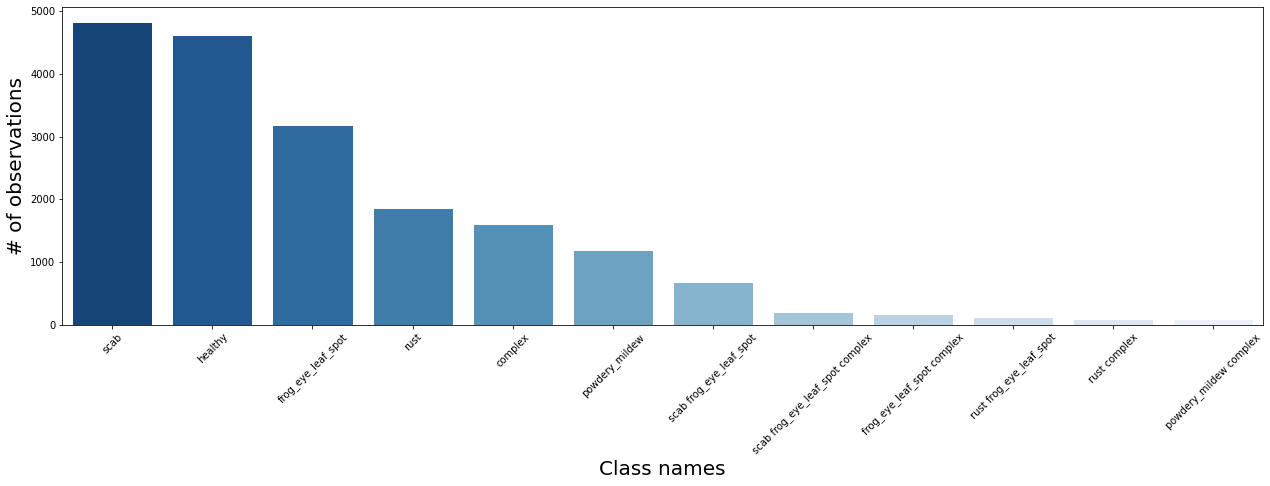

In [15]:
plot_image_counts(img_labels)  

In [16]:
img_labels.head()

,labels
image,
ae7a52cc3cc3241f.jpg,healthy
b2a08e9bf8f061a7.jpg,scab frog_eye_leaf_spot
806878cdcb8df99a.jpg,scab frog_eye_leaf_spot complex
f5139361351a6b99.jpg,powdery_mildew complex
a39bd3c311438f3c.jpg,healthy


## One hot encoding

In [17]:
def get_single_labels(unique_labels) -> List[str]:
    single_labels = []
    
    for label in unique_labels:
        single_labels += label.split()
        
    single_labels = set(single_labels)
    return list(single_labels)

In [18]:
def get_one_hot_encoded_labels(dataset_df) -> pd.DataFrame:
    df = dataset_df.copy()
    
    unique_labels = df.labels.unique()
    column_names = get_single_labels(unique_labels)
    
    df[column_names] = 0        
    
    # one-hot-encoding
    for label in unique_labels:                
        label_indices = df[df['labels'] == label].index
        splited_labels = label.split()
        df.loc[label_indices, splited_labels] = 1
    
    return df

In [19]:
one_hot_encoded_labels = get_one_hot_encoded_labels(img_labels)
one_hot_encoded_labels.head()

,labels,frog_eye_leaf_spot,rust,scab,powdery_mildew,healthy,complex
image,,,,,,,
ae7a52cc3cc3241f.jpg,healthy,0,0,0,0,1,0
b2a08e9bf8f061a7.jpg,scab frog_eye_leaf_spot,1,0,1,0,0,0
806878cdcb8df99a.jpg,scab frog_eye_leaf_spot complex,1,0,1,0,0,1
f5139361351a6b99.jpg,powdery_mildew complex,0,0,0,1,0,1
a39bd3c311438f3c.jpg,healthy,0,0,0,0,1,0


## Visualization of images

In [20]:
def get_image(image_id, kind='train'):
    fname = os.path.join(Config.folders[kind], image_id)
    return PIL.Image.open(fname)

In [21]:
def visualize_images(image_ids, labels, nrows=1, ncols=4, kind='train', image_transform=None):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 8))
    for image_id, label, ax in zip(image_ids, labels, axes.flatten()):
        
        fname = os.path.join(Config.folders[kind], image_id)
        image = np.array(PIL.Image.open(fname))
        
        if image_transform:
            image = transform = A.Compose(
                [t for t in image_transform.transforms if not isinstance(t, (
                    A.Normalize, 
                    ToTensorV2
                ))])(image=image)['image']
        
        io.imshow(image, ax=ax)
        
        ax.set_title(f"Class: {label}", fontsize=12)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        del image
        
    plt.show()

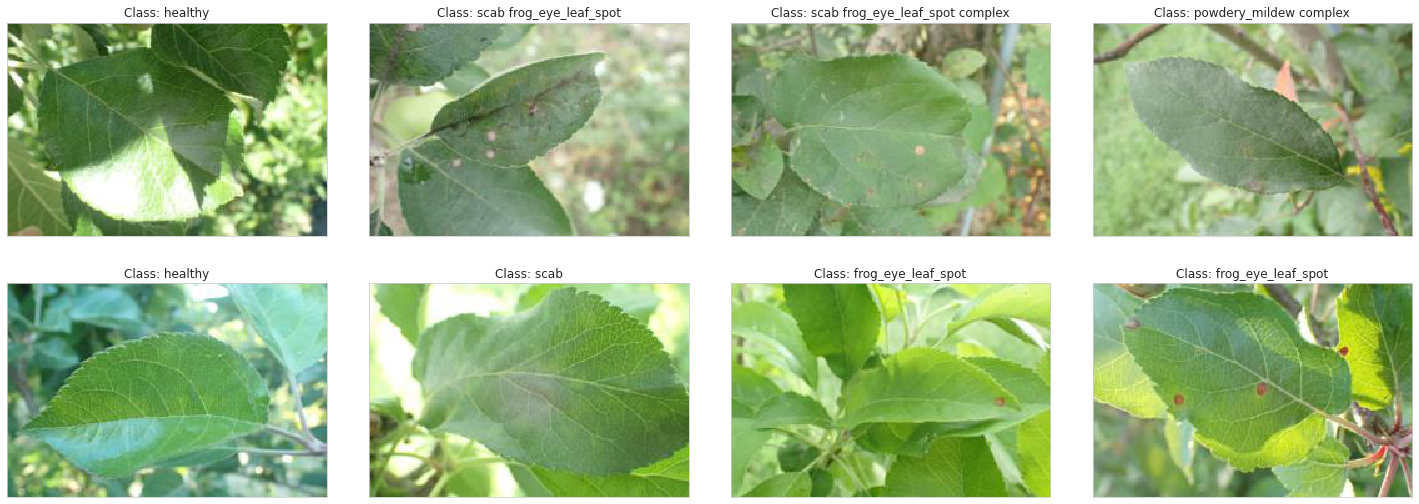

In [22]:
visualize_images(img_labels.index, img_labels.labels, nrows=2, ncols=4)

## Augmentation Transform Pipeline

In [23]:
train_transform = A.Compose([
    A.Rotate(
        always_apply=False, 
        p=0.1, 
        limit=10, 
        interpolation=1, 
        border_mode=0, 
        value=(0, 0, 0), 
        mask_value=None
    ),
    A.RandomShadow(
        num_shadows_lower=1, 
        num_shadows_upper=1, 
        shadow_dimension=3, 
        shadow_roi=(0, 0.6, 1, 1), 
        p=0.4
    ),
    A.ShiftScaleRotate(
        shift_limit=0.1, 
        scale_limit=0.1, 
        rotate_limit=10, 
        p=0.6
    ),
    A.RandomFog(
        fog_coef_lower=0.2, 
        fog_coef_upper=0.2, 
        alpha_coef=0.2, 
        p=0.3
    ),
    A.RGBShift(
        r_shift_limit=15, 
        g_shift_limit=15, 
        b_shift_limit=15, 
        p=0.3
    ),
    A.RandomBrightnessContrast(
        p=0.3
    ),
    A.GaussNoise(
        var_limit=(50, 70),  
        always_apply=False, 
        p=0.3
    ),
    A.Resize(
        height=Config.IMG_SIZE,
        width=Config.IMG_SIZE,
    ),
    A.CoarseDropout(
        max_holes=5, 
        max_height=5, 
        max_width=5, 
        min_holes=3, 
        min_height=5, 
        min_width=5,
        always_apply=False, 
        p=0.2
    ),
    A.Normalize(
        mean=(0.485, 0.456, 0.406), 
        std=(0.229, 0.224, 0.225)
    ),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(
        height=Config.IMG_SIZE,
        width=Config.IMG_SIZE,
    ),
    A.Normalize(
        mean=(0.485, 0.456, 0.406), 
        std=(0.229, 0.224, 0.225)
    ),
    ToTensorV2(),
])

In [24]:
images = img_labels.sample(n=5)

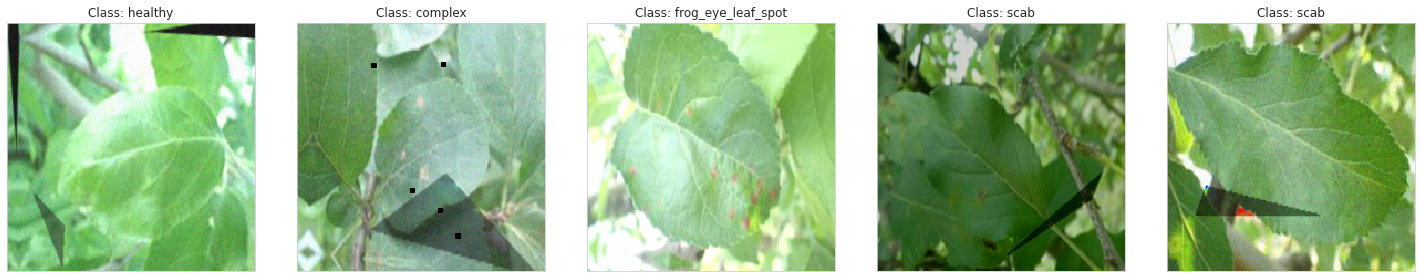

In [25]:
visualize_images(
    images.index, 
    images.labels, 
    nrows=1,
    ncols=5,
    image_transform=train_transform,
    kind='train'
)

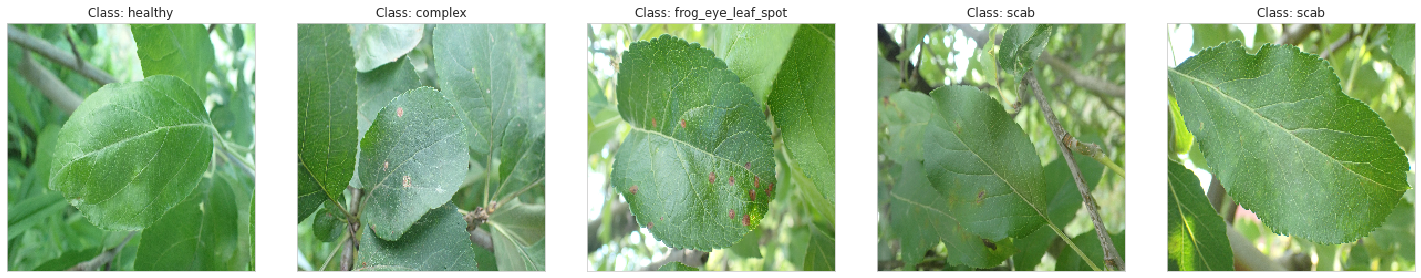

In [26]:
visualize_images(
    images.index, 
    images.labels, 
    nrows=1,
    ncols=5,
    image_transform=val_transform,
    kind='test'
)

## Dataset Class

In [27]:
from scipy.stats import bernoulli
from torch.utils.data import Dataset

class PlantDataset(Dataset):
    def __init__(self, 
                 image_ids, 
                 targets,
                 transform=None, 
                 target_transform=None, 
                 kind='train'):
        self.image_ids = image_ids
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform
        self.kind = kind
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        img = np.array(get_image(self.image_ids.iloc[idx], kind=self.kind))
        
        if self.transform:
            img = self.transform(image=img)['image']
        
        target = self.targets[idx]
        if self.target_transform:
            target = self.target_transform(target)
        
        return img, target

## Train Test Split

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_vaild, y_train, y_vaild = train_test_split(
    pd.Series(img_labels.index), 
    np.array(one_hot_encoded_labels[Config.CLASSES]),  
    test_size=Config.TEST_SIZE, 
    random_state=Config.RANDOM_STATE
)

## Create Model

In [29]:
def load_model(model, load_path=Config.INPUT_MODEL_FILE):
    model.load_state_dict(torch.load(load_path))
    model.eval()
    
def save_weights(model, save_path=Config.OUTPUT_MODEL_FILE):
    torch.save(model.state_dict(), save_path)

def create_model(pretrained, model_name):
    if model_name == 'alexnet':
        model = torchvision.models.alexnet(pretrained=pretrained).to(Config.DEVICE)
        model.classifier[6] = torch.nn.Sequential(
            torch.nn.Linear(in_features=4096, out_features=Config.N_CLASSES),
            torch.nn.Sigmoid(),
        ).to(Config.DEVICE)
    elif model_name == 'vggnet':
        model = torchvision.models.vgg19(pretrained=pretrained).to(Config.DEVICE)
        model.classifier[6] = torch.nn.Sequential(
                torch.nn.Linear(in_features=4096, out_features=Config.N_CLASSES),
                torch.nn.Sigmoid(),
            ).to(Config.DEVICE)
    elif model_name == 'resnet':
        model = torchvision.models.resnet50(pretrained=pretrained).to(Config.DEVICE)
        model.fc = torch.nn.Sequential(
            torch.nn.Linear(in_features=model.fc.in_features, out_features=Config.N_CLASSES),
            torch.nn.Sigmoid(),
        ).to(Config.DEVICE)
    else :
        model = torchvision.models.densenet121(pretrained=pretrained).to(Config.DEVICE)
        model.classifier = torch.nn.Sequential(
            torch.nn.Linear(in_features=model.classifier.in_features, out_features=Config.N_CLASSES),
            torch.nn.Sigmoid(),
        ).to(Config.DEVICE)
    return model

## Track Metrics

In [30]:
class MetricMonitor:
    def __init__(self):
        self.reset()

    def reset(self):
        self.losses = []
        self.accuracies = []
        self.scores = []
        self.metrics = dict({
            'loss': self.losses,
            'acc': self.accuracies,
            'f1': self.scores
        })

    def update(self, metric_name, value):
        self.metrics[metric_name] += [value]

In [31]:
from sklearn.metrics import f1_score, accuracy_score

def get_metrics(
    y_pred_proba, 
    y_test, 
    threshold=Config.CLASS_THRESHOLD,
    labels=Config.CLASSES) -> None:
    
    y_pred = np.where(y_pred_proba > threshold, 1, 0)
    y1 = y_pred.round().astype(np.float)
    y2 = y_test.round().astype(np.float)
    
    f1 = f1_score(y1, y2, average='micro')
    acc = accuracy_score(y1, y2, normalize=True)

    return acc, f1

## Epoch Loop

In [32]:
def training_loop(
    dataloader, 
    model, 
    loss_fn, 
    optimizer, 
    epoch, 
    config,
    monitor = MetricMonitor(), 
    is_train=True
) -> bool:
    size = len(dataloader.dataset)
    loss_val = 0
    accuracy = 0
    f1score = 0
    
    if is_train:
        model.train()
    else:
        model.eval()
    wandb.watch(model, loss_fn, log="all", log_freq=10)
    stream = tqdm(dataloader)
    for batch, (X, y) in enumerate(stream, start=1):
        X = X.to(Config.DEVICE)
        if config.loss_function == 'binary cross entropy':
            X = X.to(torch.float32)
        y = y.to(Config.DEVICE)
        if config.loss_function == 'binary cross entropy':
            y = y.to(torch.float32)
        
        pred_prob = model(X)
        if config.loss_function == 'binary cross entropy':
            pred_prob = pred_prob.to(torch.float32)
        loss = loss_fn(pred_prob, y)
    
        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        
        loss_val += loss.item()
        acc, f1 = get_metrics(to_numpy(pred_prob), to_numpy(y))
        
        accuracy += acc 
        f1score += f1
        phase = 'Train' if is_train else 'Val'
        stream.set_description(
            f'Epoch {epoch:3d}/{config.epochs} - {phase} - Loss: {loss_val/batch:.4f}, ' + 
            f'Acc: {accuracy/batch:.4f}, F1: {f1score/batch:.4f}'
        )
        wandb.log({'f1 score':f1score/batch})
        wandb.log({'loss':loss_val/batch})
        if is_train:
            wandb.log({'train f1 score':f1score/batch})
            wandb.log({'train loss':loss_val/batch})
        else:
            wandb.log({'val f1 score':f1score/batch})
            wandb.log({'val loss':loss_val/batch})
        if f1score/batch <= 0.15:
            return True
    monitor.update('loss', loss_val/batch)
    monitor.update('acc', accuracy/batch)
    monitor.update('f1', f1score/batch) 
    return False

In [33]:
train_monitor = MetricMonitor()
test_monitor = MetricMonitor()

## Complete Pipeline 

In [34]:
def model_pipeline(config_defaults):
    
    wandb.init(project="green doctor", config=config_defaults)
    config = wandb.config
    
    train_set = PlantDataset(X_train, y_train, transform=train_transform, kind='train')
    val_set = PlantDataset(X_vaild, y_vaild, transform=val_transform, kind='val')
    model = create_model(True, config.architecture)
    train_loader = DataLoader(train_set, batch_size=config.batch_size, shuffle=True)
    valid_loader = DataLoader(val_set, batch_size=config.batch_size, shuffle=True)
    if config.loss_function == 'binary cross entropy':
        loss_fn = nn.BCELoss()
    elif config.loss_function == 'multi label softmargin':
        loss_fn = nn.MultiLabelSoftMarginLoss()
    if config.optimizer=='sgd':
        optimizer = optim.SGD(model.parameters(),lr=config.learning_rate, momentum=0.9)
    elif config.optimizer=='adam':
        optimizer = optim.Adam(model.parameters(),lr=config.learning_rate)
    terminateRun = False
    for epoch in range(1, config.epochs + 1):
        terminateRun |= training_loop(
            train_loader, 
            model, 
            loss_fn, 
            optimizer, 
            epoch, 
            config,
            train_monitor,
            is_train=True
        )
        if terminateRun:
            break
        terminateRun |= training_loop(
            valid_loader, 
            model, 
            loss_fn, 
            optimizer, 
            epoch, 
            config,
            test_monitor,
            is_train=False
        )
        if terminateRun:
            break
    return model

In [35]:
torch.cuda.empty_cache()
model = model_pipeline(config_defaults)

wandb: Currently logged in as: divesh2201 (use `wandb login --relogin` to force relogin)
2021-10-13 10:13:26.656104: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]


CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

## Plot metrics

In [36]:
from matplotlib.ticker import MaxNLocator 

def plot_result(
    train_losses, 
    test_losses, 
    train_accuracies, 
    test_accuracies, 
    train_scores,
    test_scores
) -> None:
    
    epochs = range(1, len(train_losses) + 1)
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22, 5))
    
    ax[0].plot(epochs, train_losses, label='Training loss', marker ='o')
    ax[0].plot(epochs, test_losses, label='Validation loss', marker ='o')
    ax[0].legend(frameon=False, fontsize=14)
    
    ax[0].get_xaxis().set_major_locator(MaxNLocator(integer=True))
    ax[0].set_title('Loss', fontsize=18)
    ax[0].set_xlabel('Epoch', fontsize=14) 
    ax[0].set_ylabel('Loss', fontsize=14)  
    
    ax[1].plot(epochs, train_accuracies, label='Training Accuracy', marker ='o')
    ax[1].plot(epochs, test_accuracies, label='Validation accuracy', marker ='o')
    ax[1].legend(frameon=False, fontsize=14)
    
    ax[1].get_xaxis().set_major_locator(MaxNLocator(integer=True))
    ax[1].set_title('Accuracy', fontsize=18)
    ax[1].set_xlabel('Epoch', fontsize=14) 
    ax[1].set_ylabel('Accuracy', fontsize=14)
    
    ax[2].plot(epochs, train_scores, label='Training F1-Score', marker ='o')
    ax[2].plot(epochs, test_scores, label='Validation F1-Score', marker ='o')
    ax[2].legend(frameon=False, fontsize=14)
    
    ax[2].get_xaxis().set_major_locator(MaxNLocator(integer=True))
    ax[2].set_title('F1-Score', fontsize=18)
    ax[2].set_xlabel('Epoch', fontsize=14) 
    ax[2].set_ylabel('F1-Score', fontsize=14) 
        
    plt.show()

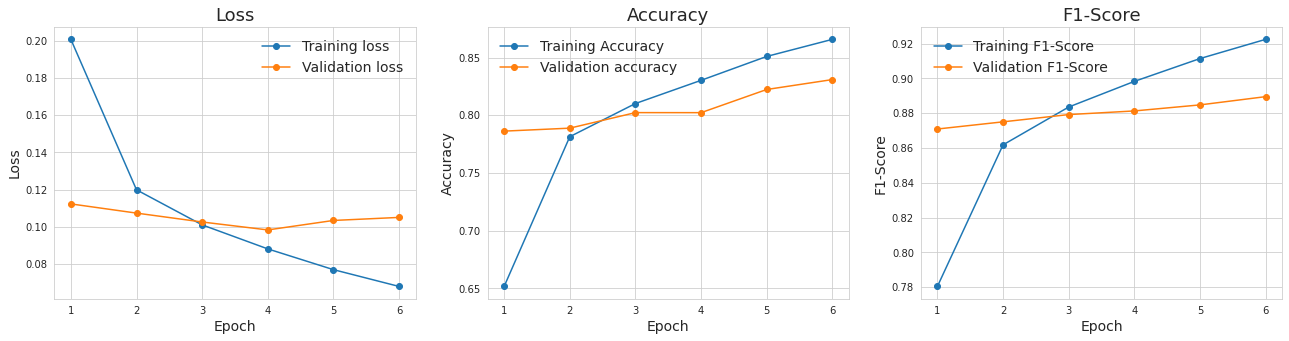

In [37]:
plot_result(
    train_monitor.losses, 
    test_monitor.losses,
    train_monitor.accuracies, 
    test_monitor.accuracies, 
    train_monitor.scores,
    test_monitor.scores
)    

## Save model and weights

In [38]:
save_weights(model)